In [1]:
import os
os.chdir("../../")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import catboost as cb
from scr.util import *

In [9]:
df = pd.read_csv('data/feature_engineered/null_cat/train_null_cat.csv')
df_submit = pd.read_csv('data/feature_engineered/null_cat/test_null_cat.csv')

### 欠損値を扱う場合

In [124]:
# df_submit_null = pd.read_csv('data/test.csv')

# age_null_id = df_submit_null.loc[df_submit_null['Age'].isna(), 'id'].values
# duration_null_id = df_submit_null.loc[df_submit_null['DurationOfPitch'].isna(), 'id'].values
# trips_null_id = df_submit_null.loc[df_submit_null['NumberOfTrips'].isna(), 'id'].values
# income_null_id = df_submit_null.loc[df_submit_null['MonthlyIncome'].isna(), 'id'].values

# for id in age_null_id:
#     df_submit.loc[df_submit['id'] == id, 'Age'] = np.nan

# for id in duration_null_id:
#     df_submit.loc[df_submit['id'] == id, 'DurationOfPitch'] = np.nan

# for id in trips_null_id:
#     df_submit.loc[df_submit['id'] == id, 'NumberOfTrips'] = np.nan

# for id in income_null_id:
#     df_submit.loc[df_submit['id'] == id, 'MonthlyIncome'] = np.nan

# Catboost

In [10]:
feature = [
    'Age',
    'TypeofContact',
    'CityTier',
    'DurationOfPitch',
    'Occupation',
    'Gender',
    'NumberOfPersonVisiting',
    'NumberOfFollowups',
    'ProductPitched',
    'PreferredPropertyStar',
    #'NumberOfTrips',
    'Passport',
    #'PitchSatisfactionScore',
    'Designation',
    'MonthlyIncome',
    'Marry',
    'Car',
    'Child',
    'ProdTaken',
    # 以下、作成特徴量
    'AgeGroup',
    #'TypeofContactNULL',
    #'Motivation',
    'EconomicPower',
    #'Child01',
    'TripEasier',
    'SalesPerformance',
    'LivingCost',
    'EconomicStability',
    'TravelCost',
    'NumberOfTrips_log',
    'EconomicSegment',
    'PackageMatch',
    #'IsFamily',
    'FreaqencySeg',
    #'Monetary',
    'MonetarySeg',
    #'ContractRate_FM',
    #'ContractRate_G1',
    #'ContractRate_G2',
    #'ContractRate_G3',
    'ContractRate_G4',
    #'ContractRate_G5',
    #'ContractRate_G6'
]

# catboostでカテゴリ変数を指定するためのリスト
category_columns = ['TypeofContact', 'CityTier', 'Occupation', 'Gender','NumberOfPersonVisiting',
                    'NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar', 'Passport',
                    'PitchSatisfactionScore', 'Designation', 'Marry', 'Car', 'Child'
                    ] + ['EconomicSegment', 'IsFamily', 'FreaqencySeg',
                        'MonetarySeg', 'ContractRate_FM', 'ContractRate_G1',
                        'ContractRate_G2', 'ContractRate_G3', 'ContractRate_G4', 'ContractRate_G5', 'ContractRate_G6'
                        ]


df = mapping_columns_if_exist(df)
df_submit = mapping_columns_if_exist(df_submit)

X = df[feature]
y = df['ProdTaken']

feature.remove('ProdTaken')
df_submit = df_submit[feature]

In [6]:
display(X.iloc[:5, 18:])
display(df_submit.iloc[:5, 17:])

,TripEasier,SalesPerformance,LivingCost,EconomicStability,TravelCost,NumberOfTrips_log,EconomicSegment,PackageMatch,FreaqencySeg,MonetarySeg,ContractRate_G4
0,48,2.351729,9.572861,16.427030,2.791759,1.791759,0,1.0,1,3,0.192308
1,8,2.375794,8.197046,18.461797,2.098612,1.098612,1,1.0,0,2,0.097046
2,24,1.875412,7.597516,16.547390,2.609438,1.609438,2,1.0,0,3,0.261860
3,8,2.147262,9.301921,14.855633,2.539721,0.693147,3,0.8,0,1,0.068441
4,48,1.731967,11.868956,12.337779,3.914157,1.609438,4,0.8,0,3,0.229050


,TripEasier,SalesPerformance,LivingCost,EconomicStability,TravelCost,NumberOfTrips_log,EconomicSegment,PackageMatch,FreaqencySeg,MonetarySeg,ContractRate_G4
0,0,1.801646,8.773409,16.526471,3.079442,2.079442,10,0.6,1,3,0.000000
1,8,1.823531,8.819260,14.755503,2.609438,1.609438,3,1.0,0,3,0.068441
2,24,1.430065,8.312294,15.086813,1.693147,0.693147,13,1.0,0,1,0.416201
3,24,1.489417,9.134037,17.829183,2.539721,0.693147,20,0.8,0,1,0.416201
4,48,1.985889,7.937675,15.127224,1.693147,0.693147,13,1.0,0,1,0.229050


In [12]:
# 学習モデル Regressor

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(skf.split(X, y))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        
        # 各foldでtarget encodingのやり直し
        tmp = tr_x.groupby(by=['AgeGroup', 'ProductPitched'], as_index=False)['ProdTaken'].mean()
        tr_x, va_x = tr_x.drop(labels='ContractRate_G4', axis=1), va_x.drop(labels='ContractRate_G4', axis=1)
        tmp = tmp.rename(columns={'ProdTaken': 'ContractRate_G4'})
        tr_x = tr_x.merge(tmp, on=['AgeGroup', 'ProductPitched'], how='left')
        va_x = va_x.merge(tmp, on=['AgeGroup', 'ProductPitched'], how='left')
        
        tr_x = tr_x.drop(labels='AgeGroup', axis=1)
        va_x = va_x.drop(labels='AgeGroup', axis=1)
        tr_x = tr_x.drop(labels='ProdTaken', axis=1)
        va_x = va_x.drop(labels='ProdTaken', axis=1)
        
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'RMSE',
    'eval_metric': 'AUC',
    'iterations': 7000,
    'learning_rate': 0.005,
    'depth': 5,
    # 'cat_features': category_columns,
    'l2_leaf_reg': 5,  # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X, y, cv_list, params)

0:	test: 0.7905769	best: 0.7905769 (0)	total: 3.17ms	remaining: 22.2s
100:	test: 0.8298161	best: 0.8332776 (41)	total: 230ms	remaining: 15.7s
200:	test: 0.8313378	best: 0.8332776 (41)	total: 495ms	remaining: 16.8s
300:	test: 0.8336120	best: 0.8338462 (296)	total: 748ms	remaining: 16.7s
400:	test: 0.8352341	best: 0.8354682 (397)	total: 1.03s	remaining: 16.9s
500:	test: 0.8371906	best: 0.8374415 (496)	total: 1.28s	remaining: 16.6s
600:	test: 0.8382441	best: 0.8383779 (593)	total: 1.52s	remaining: 16.2s
700:	test: 0.8394983	best: 0.8395987 (667)	total: 1.72s	remaining: 15.5s
800:	test: 0.8406689	best: 0.8406689 (800)	total: 1.92s	remaining: 14.9s
900:	test: 0.8416388	best: 0.8418060 (897)	total: 2.18s	remaining: 14.8s
1000:	test: 0.8420067	best: 0.8421070 (999)	total: 2.43s	remaining: 14.6s
1100:	test: 0.8423244	best: 0.8423579 (1099)	total: 2.7s	remaining: 14.5s
1200:	test: 0.8422408	best: 0.8424415 (1130)	total: 2.96s	remaining: 14.3s
1300:	test: 0.8429766	best: 0.8431104 (1290)	total: 

In [16]:
# モデルを保存
# ベストモデルを保存中
# 学習データセットについて、意味がある欠損値2つ以外を削除した学習データセット。

# for i, model in enumerate(models):
#     with open ('model/catboost/catboost_model_{}.pkl'.format(i), 'wb') as f:
#         pickle.dump(model, f)

In [84]:
X = X.drop(labels='ProdTaken', axis=1)

     feature_importance           column  fold
0              4.310806              Age     1
1              2.063193    TypeofContact     1
2              2.058808         CityTier     1
3              0.663760  DurationOfPitch     1
4              1.247273       Occupation     1
..                  ...              ...   ...
175            0.398127         IsFamily     5
176            0.368350     FreaqencySeg     5
177            2.774360         Monetary     5
178            0.706558      MonetarySeg     5
179            6.671156  ContractRate_G4     5

[180 rows x 3 columns]


C:\Users\ricke\AppData\Local\Temp\ipykernel_7600\4245149276.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=feature_importance_df,


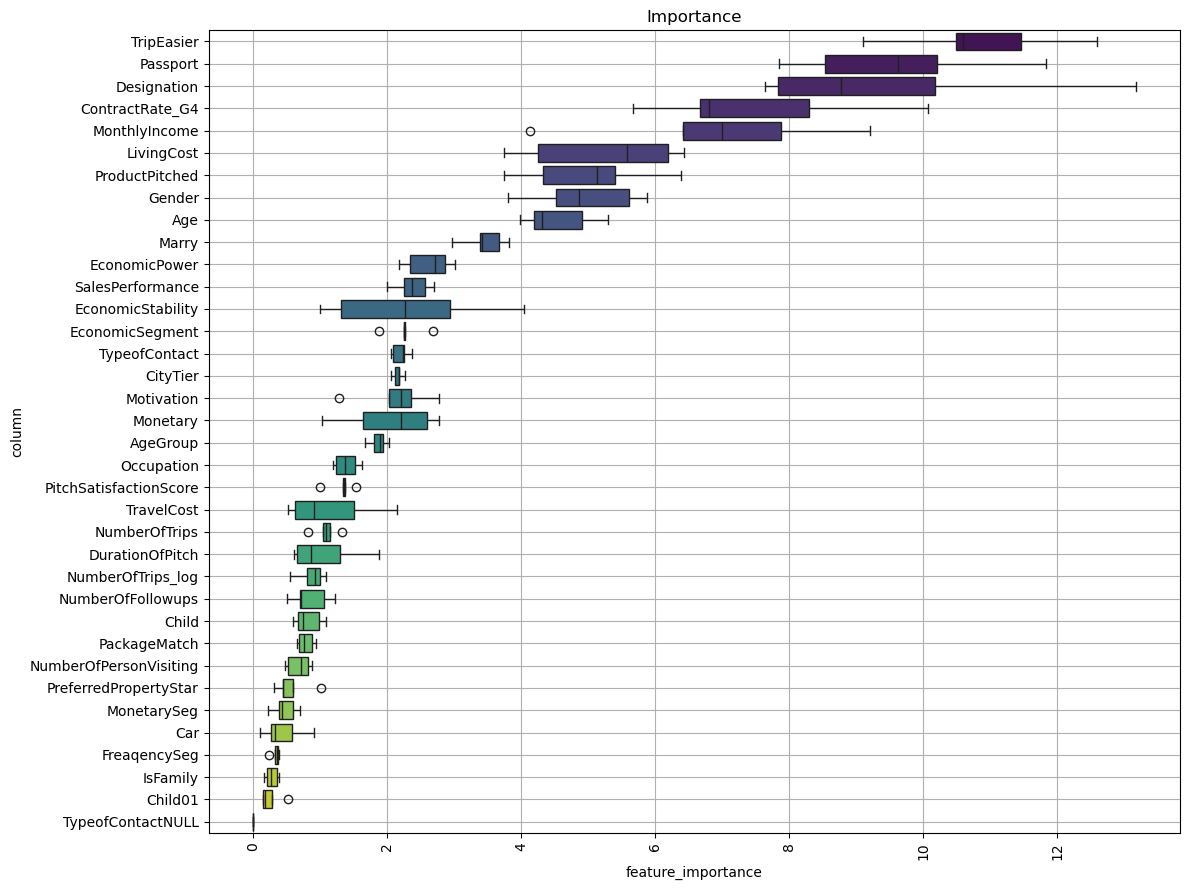

In [85]:
# 特徴量の重要度

def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                        axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    print(feature_importance_df)
    #feature_importance_df_drop_speed = feature_importance_df[feature_importance_df["column"] != "speed"]
    sns.boxplot(data=feature_importance_df,
                x="feature_importance",
                y="column",
                order=order,
                ax=ax,
                palette="viridis",
                orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, X)

# Classifier

In [12]:
# 学習モデル Classifier

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=50)
cv_list = list(skf.split(X, y))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostClassifier(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict_proba(va_x)[:, 1]
        models.append(model)
    return oof_pred, models

params = {
    'scale_pos_weight': 497/2992,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 8000,
    'learning_rate': 0.005,
    'depth': 5,
    # 'cat_features': category_columns,
    'l2_leaf_reg': 7,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X, y, cv_list, params)

0:	test: 0.7193144	best: 0.7193144 (0)	total: 11.3ms	remaining: 1m 30s
100:	test: 0.7825418	best: 0.7829431 (79)	total: 273ms	remaining: 21.4s
200:	test: 0.7825585	best: 0.7840970 (126)	total: 525ms	remaining: 20.4s
300:	test: 0.7855351	best: 0.7858863 (284)	total: 806ms	remaining: 20.6s
400:	test: 0.7885284	best: 0.7885284 (400)	total: 1.08s	remaining: 20.5s
500:	test: 0.7893144	best: 0.7896488 (470)	total: 1.37s	remaining: 20.5s
600:	test: 0.7899498	best: 0.7902007 (597)	total: 1.65s	remaining: 20.3s
700:	test: 0.7897157	best: 0.7904348 (622)	total: 1.93s	remaining: 20.1s
800:	test: 0.7899498	best: 0.7904348 (622)	total: 2.19s	remaining: 19.7s
900:	test: 0.7899666	best: 0.7904348 (622)	total: 2.48s	remaining: 19.5s
1000:	test: 0.7900836	best: 0.7904348 (622)	total: 2.78s	remaining: 19.5s
1100:	test: 0.7898495	best: 0.7904348 (622)	total: 3.06s	remaining: 19.2s
1200:	test: 0.7898997	best: 0.7904348 (622)	total: 3.32s	remaining: 18.8s
1300:	test: 0.7899331	best: 0.7904348 (622)	total: 

# 提出

In [32]:
# for col in category_columns:
#     df_submit[col] = df_submit[col].astype('str')

y_submit = np.zeros(len(df_submit))
for model in models:
    y_submit += model.predict(df_submit) / len(models)

index = pd.read_csv('data/test.csv')['id'].values
df_submit = pd.DataFrame({
    "id": index,
    "prediction": y_submit
})

df_submit['prediction'] = np.where(df_submit['prediction'] < 0, 0, df_submit['prediction'])
df_submit.head()

,id,prediction
0,3489,0.065666
1,3490,0.156267
2,3491,0.323386
3,3492,0.382348
4,3493,0.346381


In [33]:
path = 'submission/submit_23_回帰モデルで補完した特徴量選択.csv'

In [34]:
df_submit.to_csv(path, index=False, header=None)

# シード値アンサンブル

In [126]:
def catboost_seed_ensemble(seed):
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    cv_list = list(skf.split(X, y))

    def train_catboost(X, y, cv, params: dict = None):
        if params is None:
            params = {}

        models = []
        n_records = len(X)
        oof_pred = np.zeros((n_records, ))
        for i, (tr_idx, va_idx) in enumerate(cv):
            tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
            tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
            model = cb.CatBoostRegressor(**params)
            model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
            oof_pred[va_idx] = model.predict(va_x)
            models.append(model)
        return oof_pred, models

    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'AUC',
        'iterations': 9000,
        'learning_rate': 0.005,
        'depth': 5,
        # 'cat_features': category_columns,
        'l2_leaf_reg': 5,  # 3 ~ 10
        'verbose': 200,
        'random_seed': 42,
    }

    oof, models = train_catboost(X, y, cv_list, params)

    y_submit = np.zeros(len(df_submit))
    for model in models:
        y_submit += model.predict(df_submit) / len(models)
    
    return y_submit

In [127]:
# 1モデル1分46秒
seed = np.arange(50)
y_submit_list = []

for seed in seed:
    y_submit = catboost_seed_ensemble(seed)
    y_submit_list.append(y_submit)

y_submit = np.sum(y_submit_list, axis=0) / len(y_submit_list)
print(y_submit)

0:	test: 0.8001294	best: 0.8001294 (0)	total: 10.3ms	remaining: 1m 32s
100:	test: 0.8267224	best: 0.8282557 (35)	total: 162ms	remaining: 14.3s
200:	test: 0.8281561	best: 0.8282955 (182)	total: 276ms	remaining: 12.1s
300:	test: 0.8272601	best: 0.8282955 (182)	total: 390ms	remaining: 11.3s
400:	test: 0.8278973	best: 0.8283951 (367)	total: 499ms	remaining: 10.7s
500:	test: 0.8276185	best: 0.8288331 (481)	total: 608ms	remaining: 10.3s
600:	test: 0.8281760	best: 0.8288331 (481)	total: 723ms	remaining: 10.1s
700:	test: 0.8281561	best: 0.8288331 (481)	total: 837ms	remaining: 9.91s
800:	test: 0.8284349	best: 0.8288331 (481)	total: 969ms	remaining: 9.92s
900:	test: 0.8275587	best: 0.8288331 (481)	total: 1.08s	remaining: 9.72s
1000:	test: 0.8274194	best: 0.8288331 (481)	total: 1.2s	remaining: 9.59s
1100:	test: 0.8268618	best: 0.8288331 (481)	total: 1.32s	remaining: 9.45s
1200:	test: 0.8264237	best: 0.8288331 (481)	total: 1.44s	remaining: 9.33s
1300:	test: 0.8255078	best: 0.8288331 (481)	total: 1

In [128]:
index = pd.read_csv('data/test.csv')['id'].values
df_submit = pd.DataFrame({
    "id": index,
    "prediction": y_submit
})

df_submit['prediction'] = np.where(df_submit['prediction'] < 0, 0, df_submit['prediction'])
df_submit.head()

,id,prediction
0,3489,0.067197
1,3490,0.216530
2,3491,0.334484
3,3492,0.412721
4,3493,0.338511


In [129]:
path = 'submission/submit_23_シード値アンサンブル.csv'

In [130]:
df_submit.to_csv(path, index=False, header=None)